Import some libraries that we will need

In [48]:
%matplotlib inline
import scipy.io
from scipy.stats import stats
from sklearn.metrics import confusion_matrix
from sklearn.svm import NuSVC
import numpy as np
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn.input_data import MultiNiftiMasker
import nibabel
from nilearn.image import new_img_like

Run SRM with the movie data

In [49]:
import brainiak.funcalign.fastsrm
help(brainiak.funcalign.fastsrm.FastSRM)

Help on class FastSRM in module brainiak.funcalign.fastsrm:

class FastSRM(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  FastSRM(atlas, n_components=20, n_iter=100, temp_dir=None, low_ram=False, random_state=None, n_jobs=1, verbose='warn')
 |  
 |  SRM decomposition using a very low amount of memory and
 |  computational power
 |  
 |  Given multi-subject data, factorize it as a shared response S among all
 |  subjects and an orthogonal transform (basis) W per subject:
 |  
 |  .. math:: X_i \approx W_i S, \forall i=1 \dots N
 |  
 |  Parameters
 |  ----------
 |  
 |  atlas :  array, shape=[n_supervoxels, n_voxels] or array, shape=[n_voxels]
 |      Probabilistic or deterministic atlas on which to project the data
 |      Deterministic atlas is an array of shape [n_voxels,] where values
 |      range from 1 to n_supervoxels. Voxels labelled 0 will be ignored.
 |  
 |  n_components : int
 |      Number of timecourses of the shared coordinates
 |  
 |  n_iter : int
 |  

Load the input data that contains the movie stimuli for unsupervised training with SRM

In [50]:
movie_file = scipy.io.loadmat('data/movie_data.mat')

Convert data to a arrays matching FastSRM input.
FastSRM is designed to work on large datasets where all data are not assumed to hold in memory. Therefore it takes as input npy files and not matrices.
Files should be loaded with np.load and represent matrix of TRs by voxels. 

In [51]:
movie_data_left = movie_file['movie_data_lh']
movie_data_right = movie_file['movie_data_rh']
subjects = movie_data_left.shape[2]
movie_data = []

# We treat these data as having only one session
paths = []
for s in range(subjects):
    # concatenate data from both hemisphere
    data_s = np.concatenate([movie_data_left[:, :, s], movie_data_right[:, :, s]], axis=0)
    # zscore the data
    data_s = stats.zscore(data_s,axis=1,ddof=1)
    # input should be n_timeframes x n_voxels to match with 
    # n_samples, n_features framework of sklearn
    data_s = data_s.T
    np.save(
        "data/movie_subject_%i" % s,
        data_s
    )
    _, n_voxels = data_s.shape
    paths.append(["data/movie_subject_%i.npy" % s])
paths = np.array(paths)

# paths is now an array of shape (number_of_subjects, number_of_sessions)
paths.shape

(10, 1)

Run FastSRM 

In [52]:
# Let's use a naive probabilistic atlas (all voxels are used)
# In practice one would choose an off-the-shelf atlas like
# nilearn.datasets.fetch_atlas_basc_multiscale_2015
A = np.eye(n_voxels)

In [53]:
srm = brainiak.funcalign.fastsrm.FastSRM(n_components=50, atlas=A)
srm.fit(paths)

temp_dir has value None. All basis (spatial maps) and reconstructed data will therefore be kept in memory.This can lead to memory errors when the number of subjects and/or sessions is large.


FastSRM(atlas=array([[1., 0., ..., 0., 0.],
       [0., 1., ..., 0., 0.],
       ...,
       [0., 0., ..., 1., 0.],
       [0., 0., ..., 0., 1.]]),
    low_ram=False, n_components=50, n_iter=100, n_jobs=1,
    random_state=None, temp_dir=None, verbose='warn')

Load the input data that contains the image stimuli and its labels for training a classifier

In [54]:
image_file = scipy.io.loadmat('data/image_data.mat')
image_data_left = image_file['image_data_lh']
image_data_right = image_file['image_data_rh']

Convert data to a list of arrays matching FastSRM input. Each element is a path to a matrix of TRs by voxels. Also, concatenate data from both hemispheres in the brain.

In [55]:
image_data = []
for s in range(subjects):
    im_data = np.concatenate([image_data_left[:, :, s], image_data_right[:, :, s]], axis=0)
    im_data = stats.zscore(im_data,axis=1,ddof=1)
    im_data = im_data.T
    np.save(
        "data/image_subject_%i" % s,
        im_data
    )
    image_data.append(["data/image_subject_%i.npy" % s])
image_data = np.array(image_data)

Z-score the Shared Response data

In [56]:
image_data_shared = [None] * subjects
for subject in range(subjects):
    image_data_shared[subject] = srm.transform(
        np.array([image_data[subject]]),
        subjects_indexes=[subject]
    )[0]
    image_data_shared[subject] = stats.zscore(image_data_shared[subject].T, axis=1, ddof=1)

Read the labels of the image data

In [57]:
labels = scipy.io.loadmat('data/label.mat')
labels = np.squeeze(labels['label'])

Run a leave-one-out cross validation with the subjects. We use a $\nu$-SVM classifier.

In [58]:
train_labels = np.tile(labels, subjects-1)
test_labels = labels
accuracy = np.zeros((subjects))
cm = [None] * subjects
for subject in range(subjects):
    # Concatenate the subjects' data for training into one matrix
    train_subjects = list(range(subjects))
    train_subjects.remove(subject)
    TRs = image_data_shared[0].shape[1]
    train_data = np.zeros((image_data_shared[0].shape[0], len(train_labels)))
    for train_subject in range(len(train_subjects)):
        start_index = train_subject*TRs
        end_index = start_index+TRs
        train_data[:, start_index:end_index] = image_data_shared[train_subjects[train_subject]]

    # Train a Nu-SVM classifier using scikit learn
    classifier = NuSVC(nu=0.5, kernel='linear')
    classifier = classifier.fit(train_data.T, train_labels)

    # Predict on the test data
    predicted_labels = classifier.predict(image_data_shared[subject].T)
    accuracy[subject] = sum(predicted_labels == test_labels)/float(len(predicted_labels))

    # Create a confusion matrix to see the accuracy of each class
    cm[subject] = confusion_matrix(test_labels, predicted_labels)

    # Normalize the confusion matrix
    cm[subject] = cm[subject].astype('float') / cm[subject].sum(axis=1)[:, np.newaxis]

Define a function that presents the output of the experiment in a plot

In [59]:
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plots a confusion matrix for each subject"""
    import matplotlib.pyplot as plt
    import math
    plt.figure()
    subjects = len(cm)
    root_subjects = math.sqrt(subjects)
    cols = math.ceil(root_subjects)
    rows = math.ceil(subjects/cols)
    classes = cm[0].shape[0]
    for subject in range(subjects):
        plt.subplot(rows, cols, subject+1)
        plt.imshow(cm[subject], interpolation='nearest', cmap=plt.cm.bone)
        plt.xticks(np.arange(classes), range(1,classes+1))
        plt.yticks(np.arange(classes), range(1,classes+1))
        cbar = plt.colorbar(ticks=[0.0,1.0], shrink=0.6)
        cbar.set_clim(0.0, 1.0)
        plt.xlabel("Predicted")
        plt.ylabel("True label")
        plt.title("{0:d}".format(subject + 1))
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

 Plot the confusion matrices and print the accuracy results

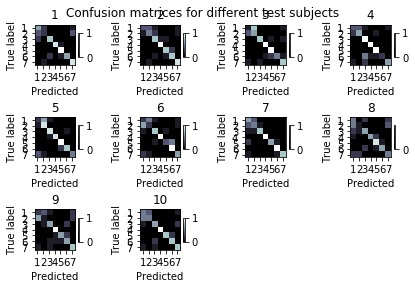

The average accuracy among all subjects is 0.671429 +/- 0.065465


In [60]:
plot_confusion_matrix(cm, title="Confusion matrices for different test subjects")
print("The average accuracy among all subjects is {0:f} +/- {1:f}".format(np.mean(accuracy), np.std(accuracy)))